# **Imports**

In [157]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import pickle
import json
import time
from os import listdir
from os.path import isfile, join
import os
import sys

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Input,Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, BatchNormalization,LSTM,Bidirectional
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D,UpSampling1D, Conv1DTranspose,GaussianNoise 
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras import backend as K
from keras.callbacks import Callback
from keras.regularizers import l2 , l1, l1_l2
import tensorflow.keras.backend as kb
print('keras version ', keras.__version__)

from IPython.display import clear_output    

from imblearn.over_sampling import SMOTE 

keras version  2.6.0


**Mount google drive**

In [159]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [160]:
TrimSecond = 1   #  2   3   5   
S = 95    #   50    90   ,   95
W = 512   #    64, 128 , 256 , 512

In [162]:
!mkdir -p dataset/sisfall

# **SisFall Orginal**

In [163]:
!unzip /content/drive/MyDrive/Keramati/FallDetection5/xvalue_orginal_all_by_subject{W}_S{S}_T{TrimSecond}.zip  -d ./dataset/sisfall/
datasetType = 'Orginal'
# train
X_train = np.load('/content/dataset/sisfall/xvalue_Train.npy')
y_train = pd.read_csv( '/content/dataset/sisfall/yvalue_Train.csv')

# validation
X_val= np.load('/content/dataset/sisfall/xvalue_Validation.npy')
y_val = pd.read_csv( '/content/dataset/sisfall/yvalue_Validation.csv')
# test
X_test= np.load('/content/dataset/sisfall/xvalue_Test.npy')
y_test = pd.read_csv('/content/dataset/sisfall/yvalue_Test.csv')

print(f'Shape of train feature is : {X_train.shape}')
print(f'Shape of train target is : {y_train.shape}')
print(f'Shape of validation feature is : {X_val.shape}')
print(f'Shape of validation target is : {y_val.shape}')
print(f'Shape of test feature is : {X_test.shape}')
print(f'Shape of test target is : {y_test.shape}')
print(y_train.iloc[:,0].value_counts() +
      y_val.iloc[:,0].value_counts() +
      y_test.iloc[:,0].value_counts())

Archive:  /content/drive/MyDrive/Keramati/FallDetection5/xvalue_orginal_all_by_subject512_S95_T1.zip
replace ./dataset/sisfall/xvalue_Train.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./dataset/sisfall/xvalue_Train.npy  
  inflating: ./dataset/sisfall/yvalue_Train.csv  
  inflating: ./dataset/sisfall/xvalue_Validation.npy  
  inflating: ./dataset/sisfall/yvalue_Validation.csv  
  inflating: ./dataset/sisfall/xvalue_Test.npy  
  inflating: ./dataset/sisfall/yvalue_Test.csv  
Shape of train feature is : (52379, 512, 9)
Shape of train target is : (52379, 5)
Shape of validation feature is : (21478, 512, 9)
Shape of validation target is : (21478, 5)
Shape of test feature is : (21819, 512, 9)
Shape of test target is : (21819, 5)
0    93427
1     2000
2      249
Name: Target, dtype: int64


# Functions

In [164]:
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [165]:
pd.options.display.float_format = '{:.1f}'.format
sns.set()
plt.style.use('ggplot') # 'Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10'

In [166]:
pd.options.display.float_format = '{:.1f}'.format
sns.set()
plt.style.use('classic')  # 'Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10'

In [167]:
y_train['nextStatus'] = y_train['Target_Time'].apply(lambda x : 0 if x == (TrimSecond + 1) else 1)
y_val['nextStatus']  = y_val['Target_Time'].apply(lambda x : 0 if x == (TrimSecond + 1) else 1)
y_test['nextStatus'] = y_test['Target_Time'].apply(lambda x : 0 if x == (TrimSecond + 1) else 1)

In [168]:
# Set input & output dimensions
num_time_periods, num_sensors = X_train.shape[1], X_train.shape[2]
print('num_sensors: '+  str(num_sensors))
print('num_time_periods: ' + str(num_time_periods))

num_sensors: 9
num_time_periods: 512


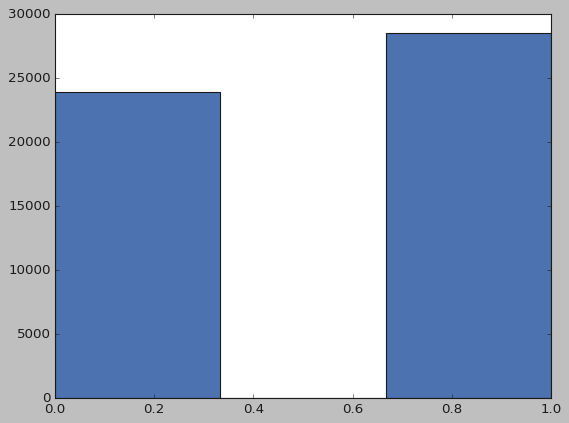

In [169]:
plt.hist(y_train['nextStatus'],bins=3);

# **Sample Weight**

In [170]:
weight = pd.Series(round(y_train['nextStatus'])).value_counts()
weight = max(weight.values) / weight 
sample_weight = y_train['nextStatus'].apply(lambda x: weight[round(x)])
sample_weight_val = y_val['nextStatus'].apply(lambda x: weight[round(x)])
print(weight)

1   1.0
0   1.2
Name: nextStatus, dtype: float64


##  Convert type for Keras otherwise Keras cannot process the data

In [171]:
X_train = X_train.astype("float32")
y_train['nextStatus'] = y_train['nextStatus'].astype("float32")
X_val = X_val.astype("float32")
y_val['nextStatus'] = y_val['nextStatus'].astype("float32")
X_test = X_test.astype("float32")
y_test['nextStatus'] = y_test['nextStatus'].astype("float32")

In [172]:
def get_Result():
    Result = {
    "Train": {"loss":[],"accuracy": []},
    "Validation": {"loss":[],"accuracy": []}}
    return Result    

class MyCallback(Callback):
    def __init__(self,Result):
        self.Result =  Result    
    def on_epoch_end(self, epoch, logs={}):                      
        Result["Train"]["loss"].append(logs['loss'])                                    
        Result["Train"]["accuracy"].append(logs['acc'])                                    
        # validation            
        Result["Validation"]["loss"].append(logs['val_loss'])                
        Result["Validation"]["accuracy"].append(logs['val_acc'])                

# **CNN**


## Build our model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 512, 9)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 512, 64)           1792      
_________________________________________________________________
batch_normalization_8 (Batch (None, 512, 64)           256       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 170, 64)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 170, 64)           12352     
_________________________________________________________________
batch_normalization_9 (Batch (None, 170, 64)           256       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 56, 64)           

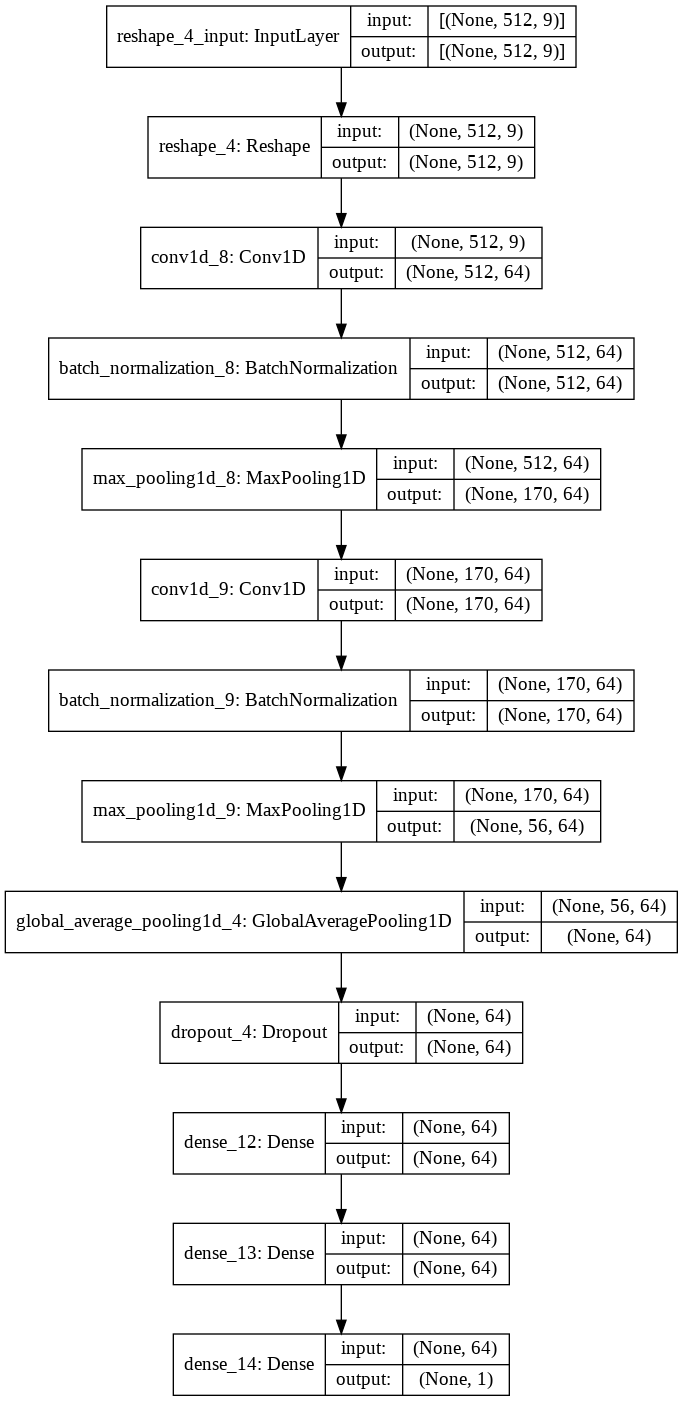

In [173]:

model_m = Sequential()
model_m.add(Reshape((num_time_periods, num_sensors), input_shape=(num_time_periods, num_sensors))) 

model_m.add(Conv1D(filters=64, kernel_size=3,padding='same', activation='relu')) #64  32   16
model_m.add(BatchNormalization())
model_m.add(MaxPooling1D(3))

model_m.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')) # 64   32   16 
model_m.add(BatchNormalization())
model_m.add(MaxPooling1D(3))

model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))

model_m.add(Dense(64, activation='relu')) # 512    256   64    32
model_m.add(Dense(64, activation='relu')) # 512    256   64    32
model_m.add(Dense(1, activation='sigmoid'))

print(model_m.summary())

plot_model(model_m, "CNN.png",show_shapes=True)

## Fit CNN the model

In [174]:
Result = get_Result()
path = f'"/content/drive/MyDrive/Keramati/FallDetection6/CNN_{datasetType}"'
!rm -r $path
!mkdir -p $path

start_time = time.time()
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Keramati/FallDetection6/CNN_' + datasetType + '/CNN_Model{epoch}.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True),                                                  
                                                  keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.8 ** (epoch // 3)),
                                                  MyCallback(Result)]                                                   
model_m.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])
                
BATCH_SIZE = 64
EPOCHS = 50
history = model_m.fit(X_train,
                      y_train['nextStatus'],
                      sample_weight= sample_weight,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,                                            
                      validation_data = (X_val, y_val['nextStatus'], sample_weight_val),
                      verbose=1)                                                                  

json.dump(str(history.history), open(f"/content/drive/MyDrive/Keramati/FallDetection6/CNN_{datasetType}/CNN_History.pkl", "w"))
json.dump(Result, open(f"/content/drive/MyDrive/Keramati/FallDetection6/CNN_{datasetType}/Result.pkl", "w"))
model_m.save(f'/content/drive/MyDrive/Keramati/FallDetection6/CNN_' + datasetType + '/CNN_Model.h5')
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/50
819/819 [==============================] - 15s 16ms/step - loss: 0.2571 - acc: 0.9003 - val_loss: 0.1503 - val_acc: 0.9437
Epoch 2/50
819/819 [==============================] - 12s 15ms/step - loss: 0.1796 - acc: 0.9305 - val_loss: 0.1716 - val_acc: 0.9387
Epoch 3/50
819/819 [==============================] - 12s 15ms/step - loss: 0.1606 - acc: 0.9363 - val_loss: 0.1288 - val_acc: 0.9507
Epoch 4/50
819/819 [==============================] - 12s 15ms/step - loss: 0.1464 - acc: 0.9425 - val_loss: 0.1164 - val_acc: 0.9550
Epoch 5/50
819/819 [==============================] - 12s 15ms/step - loss: 0.1405 - acc: 0.9455 - val_loss: 0.1281 - val_acc: 0.9520
Epoch 6/50
819/819 [==============================] - 12s 14ms/step - loss: 0.1364 - acc: 0.9468 - val_loss: 0.1213 - val_acc: 0.9561
Epoch 7/50
819/819 [==============================] - 13s 16ms/step - loss: 0.1286 - acc: 0.9495 - val_loss: 0.1260 - val_acc: 0.9545
Epoch 8/50
819/819 [==============================] - 12s 15ms

# **Show result**

In [175]:
structure = "CNN"
path = f'/content/drive/MyDrive/Keramati/FallDetection6/{structure}_{datasetType}/'
files = [f for f in listdir(path) if(isfile(join(path, f)) and f.endswith('.h5'))]  # read all file in path                           
BestEpoch = int(sorted(files, key=lambda x: (len (x), x))[-1].split('Model')[1].split('.h5')[0])
model_m = keras.models.load_model(path+ f'{structure}_Model{BestEpoch}.h5')
Result = json.load(open(path +"Result.pkl", 'r'))
Epochs = len(Result['Train']['accuracy'])
print(BestEpoch)

23


In [176]:
pd.options.display.float_format = '{:.1f}'.format
sns.set()
plt.style.use('seaborn-white')  # 'Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10'
plt.style.use('seaborn-whitegrid')  # 'Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10'

## **Plots**

0.08664047718048096
Train loss for last epoch : 0.0866
Train loss for best epoch : 0.097


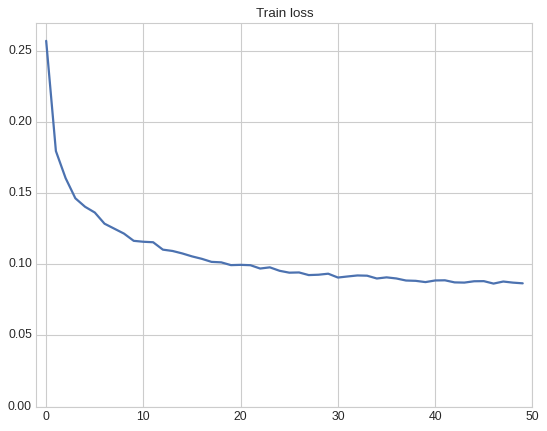

Validation loss for last epoch : 0.0999
Validation loss for best epoch : 0.0954


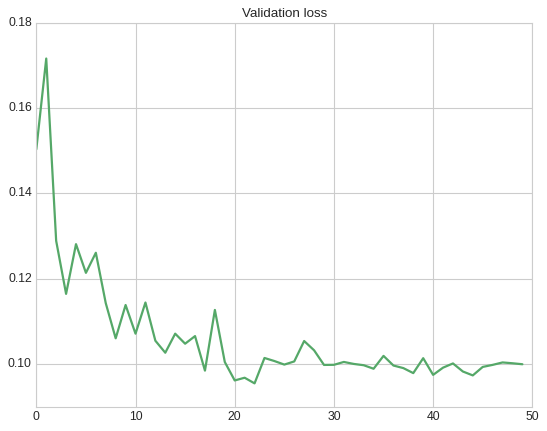

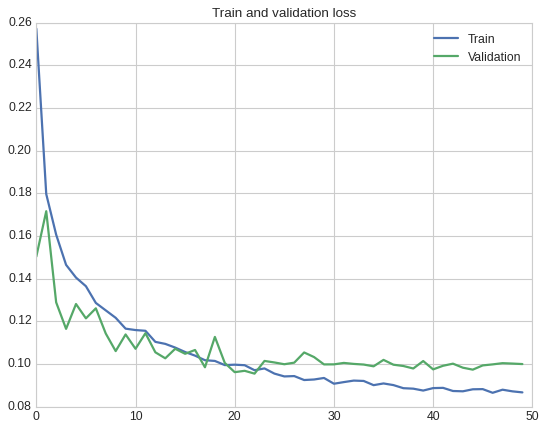

In [177]:
linewidth = 2
figsize=(8, 6) 

print(Result["Train"]["loss"][-1])
print(f'Train loss for last epoch : {round(Result["Train"]["loss"][-1], 4)}')
print(f'Train loss for best epoch : {round(Result["Train"]["loss"][BestEpoch - 1], 4)}')
plt.figure(num=None, figsize=figsize, dpi=80, facecolor='w', edgecolor='k')
plt.plot(Result["Train"]["loss"],'b',linewidth=linewidth)
plt.title(f'Train loss')
plt.axis([-1, Epochs, 0, max(Result["Train"]["loss"]) + 0.05 * max(Result["Train"]["loss"])])
plt.show()
print(f'Validation loss for last epoch : {round(Result["Validation"]["loss"][-1], 4)}')
print(f'Validation loss for best epoch : {round(Result["Validation"]["loss"][BestEpoch - 1], 4)}')
plt.figure(num=None, figsize=figsize, dpi=80, facecolor='w', edgecolor='k')
plt.plot(Result["Validation"]["loss"],'g',linewidth=linewidth)
plt.title(f'Validation loss')
#plt.axis([-1, Epochs, 0, max(Result["Train"]["loss"]) + 0.05 * max(Result["Train"]["loss"])])
plt.show()
plt.figure(num=None, figsize=figsize, dpi=80, facecolor='w', edgecolor='k')
plt.plot(Result["Train"]["loss"],'b',linewidth=linewidth)
plt.plot(Result["Validation"]["loss"],'g',linewidth=linewidth)
plt.title(f'Train and validation loss')
plt.legend(['Train', 'Validation'], loc='upper right')    

#plt.axis([-1, Epochs, 0, max(Result["Train"]["loss"]) + 0.05 * max(Result["Train"]["loss"])])
plt.show()

# Accuracy

Train accuracy for last epoch : 96.58%
Train accuracy for best epoch : 96.18%


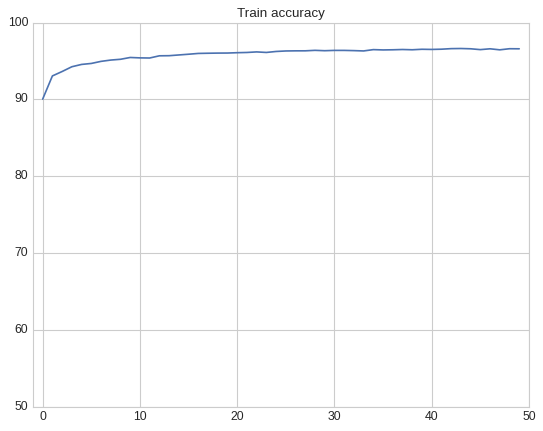

Validation accuracy for last epoch : 96.58%
Validation accuracy for best epoch : 96.5%


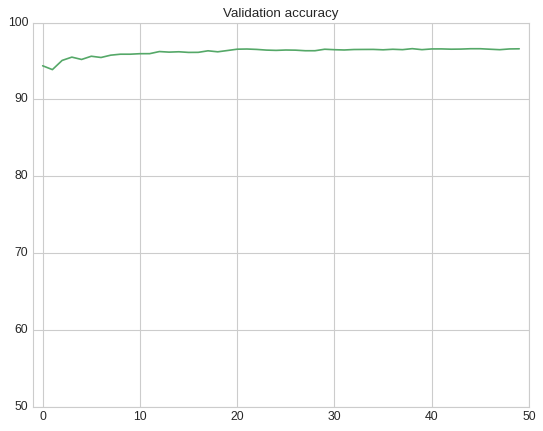

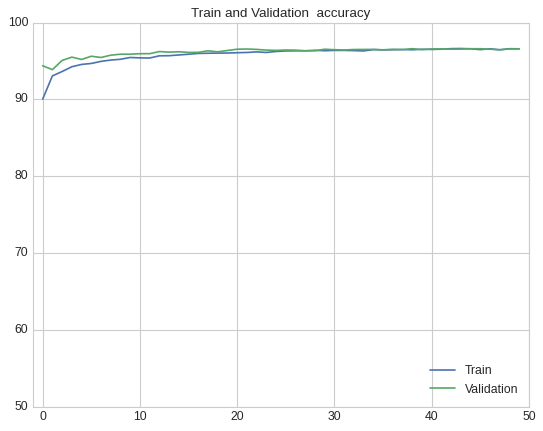

In [179]:
Min = 50
print(f'Train accuracy for last epoch : {round(Result["Train"]["accuracy"][-1] * 100 , 2)}%')
print(f'Train accuracy for best epoch : {round(Result["Train"]["accuracy"][BestEpoch - 1] * 100 , 2)}%')
plt.plot(np.array(Result["Train"]["accuracy"]) * 100,'b') 
plt.title(f'Train accuracy')
plt.axis([-1, Epochs, Min, 100])
plt.show()

print(f'Validation accuracy for last epoch : {round(Result["Validation"]["accuracy"][-1] * 100,2)}%')
print(f'Validation accuracy for best epoch : {round(Result["Validation"]["accuracy"][BestEpoch - 1] * 100,2)}%')
plt.plot(np.array(Result["Validation"]["accuracy"]) * 100,'g')
plt.title(f'Validation accuracy')
plt.axis([-1, Epochs, Min, 100])
plt.show()


plt.plot(np.array(Result["Train"]["accuracy"])*100,'b')
plt.plot(np.array(Result["Validation"]["accuracy"])*100,'g')
plt.title(f'Train and Validation  accuracy')
plt.axis([-1, Epochs, Min, 100])
plt.legend(['Train', 'Validation'], loc='lower right')    

plt.show()

# Confusion metrix

In [180]:
LABELS = ['bkg', 'fall']
def show_confusion_matrix(matrix):
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,cmap="Blues",linecolor='white',linewidths=1,xticklabels=LABELS,yticklabels=LABELS,annot=True,fmt=".2f")        
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

def confusion_matrix(validations, predictions):        
    matrix = metrics.confusion_matrix(validations, predictions)            
    show_confusion_matrix(matrix) # show for frequency        
    sensitivity =  np.divide(matrix.transpose(),np.sum(matrix, axis=1)).transpose() * 100
    show_confusion_matrix(sensitivity) # show for sensitivity                    

## Train

In [ ]:
pred =np.round(model_m.predict(X_train))
true_label = y_train['nextStatus']
confusion_matrix(true_label, pred)    

# Validation

In [ ]:
pred = np.round(model_m.predict(X_val))
true_label = y_val['nextStatus']
confusion_matrix(true_label, pred)    

# Test

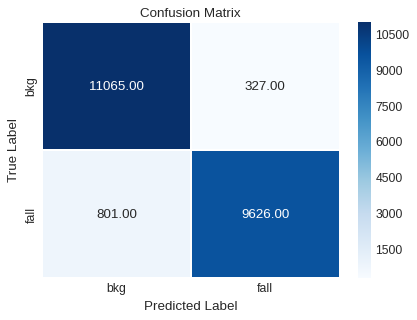

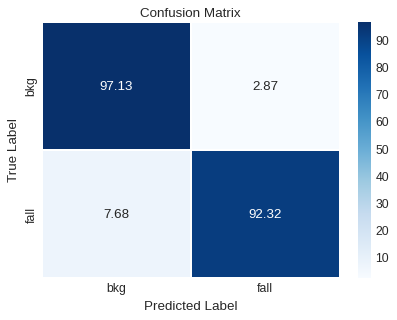

In [181]:
pred =np.round(model_m.predict(X_test))
true_label = y_test['nextStatus']
confusion_matrix(true_label, pred)    

# Show

In [182]:
#!wget http://sistemic.udea.edu.co/wp-content/uploads/2016/03/SisFall_dataset.zip
!cp /content/drive/MyDrive/Keramati/SisFall_dataset.zip  ./
!mkdir -p dataset/sisfall
!unzip ./SisFall_dataset.zip   -d ./dataset/sisfall/
!rm ./SisFall_dataset.zip
!mv ./dataset/sisfall/SisFall_dataset/ ./dataset/sisfall/values
!unzip /content/drive/MyDrive/Keramati/FallDetection1b/lables.zip   -d ./dataset/sisfall/
def standars(df):
    df = df.copy()
    Mean= df.mean()
    Std = df.std()
    df = (df- Mean) / Std
    return df

X_Train = np.load('/content/dataset/sisfall/xvalue_Train.npy')
y_train = pd.read_csv('/content/dataset/sisfall/yvalue_Train.csv')
y_train['nextStatus'] = y_train['Target_Time'].apply(lambda x : 0 if x == (TrimSecond + 1) else 1)
y_train.index = range(0,len(y_train))

X_Val = np.load('/content/dataset/sisfall/xvalue_Validation.npy')
y_val = pd.read_csv('/content/dataset/sisfall/yvalue_Validation.csv')
y_val['nextStatus'] = y_val['Target_Time'].apply(lambda x : 0 if x == (TrimSecond + 1) else 1)
y_val.index = range(len(y_train),len(y_train)+len(y_val))

X_Test = np.load('/content/dataset/sisfall/xvalue_Test.npy')
y_test = pd.read_csv('/content/dataset/sisfall/yvalue_Test.csv')
y_test['nextStatus'] = y_test['Target_Time'].apply(lambda x : 0 if x == (TrimSecond + 1) else 1)
y_test.index = range(len(y_train)+len(y_val),len(y_train)+len(y_val)+len(y_test))

Streaming output truncated to the last 5000 lines.
  inflating: ./dataset/sisfall/SisFall_dataset/SE07/D15_SE07_R04.txt  
  inflating: ./dataset/sisfall/SisFall_dataset/SE07/D15_SE07_R05.txt  
  inflating: ./dataset/sisfall/SisFall_dataset/SE07/D16_SE07_R01.txt  
  inflating: ./dataset/sisfall/SisFall_dataset/SE07/D16_SE07_R02.txt  
  inflating: ./dataset/sisfall/SisFall_dataset/SE07/D16_SE07_R03.txt  
  inflating: ./dataset/sisfall/SisFall_dataset/SE07/D16_SE07_R04.txt  
  inflating: ./dataset/sisfall/SisFall_dataset/SE07/D16_SE07_R05.txt  
  inflating: ./dataset/sisfall/SisFall_dataset/SE07/D17_SE07_R01.txt  
  inflating: ./dataset/sisfall/SisFall_dataset/SE07/D17_SE07_R02.txt  
  inflating: ./dataset/sisfall/SisFall_dataset/SE07/D17_SE07_R03.txt  
  inflating: ./dataset/sisfall/SisFall_dataset/SE07/D17_SE07_R04.txt  
  inflating: ./dataset/sisfall/SisFall_dataset/SE07/D17_SE07_R05.txt  
  inflating: ./dataset/sisfall/SisFall_dataset/SE07/desktop.ini  
  inflating: ./dataset/sisfall/

In [183]:
X_global = np.concatenate((X_train, X_val, X_test))
y_global = pd.concat([y_train, y_val, y_test])
def get_data(Subjet, Type, Repeat):    
    y = y_global[y_global['subId']==Subjet]
    y = y[y['activiteId'] == Type]
    y = y[y['repeat'] == Repeat]
    X = X_global[y.index]
    path = f"/content/dataset/sisfall/values/{Subjet}/{Type}_{Subjet}_{Repeat}.txt"
    df = pd.read_csv(path ,header=None)        
    df.iloc[:,-1] = df.iloc[:,-1].apply(lambda x: float(str(x).replace(';',''))) # remove ; from last column   
    df = standars(df)        
    dfl = pd.read_csv(path.replace('values','lables'),header=None)
    return [X, y, df, dfl]

In [184]:
def run(Subjet = "SA01",Type = "F01",Repeat = "R01",show=False, post_process = 0):
    [X, y, df, dfl] = get_data(Subjet = Subjet ,Type = Type, Repeat = Repeat)    
    pred_index = [W]
    pred_value = [p[0] for p in model_m.predict(X)]        
    stride = int(W * 0.5)
    slow_stride = int(W * round(1 - S/100,3))    
    x = []
    last = 0
    for i in range(X.shape[0]):
        l = y.iloc[i,:]['nextStatus']                 
        if(l==0):                    
            for j in X[i][0:stride]:        
                x.append(j[0])        
            pred_index.append(pred_index[-1]+stride)
            last = 0
        else:
            for j in X[i][0:slow_stride]:        
                x.append(j[0])            
            pred_index.append(pred_index[-1]+slow_stride)
            last = 1
    if(last == 0):
        for j in X[-1][stride:]:        
            x.append(j[0])        
    if(last == 1):
        for j in X[-1][slow_stride:]:        
            x.append(j[0])        
    pred_index = pred_index[:-1]
    pred = [ round(p) for p in pred_value]
    
    # post-process 
    if(post_process > 0):        
        pred2 = pred.copy()        
        for i in range(post_process, len(pred2)):    
            l = pred[(i-post_process):i+1]            
            pred2[i] = max(l,key=l.count)            
        pred = pred2        
    #
    true_value = (y['Target_Time'] != TrimSecond + 1).apply(lambda x : 1 if x else 0)    
    both = true_value * pred
    if(show):
        print(f"predict: {pred}")        
        if(post_process > 0):        
            print(f"post predict: {pred2}")        
        print(f"true_value: {true_value.values}")        
        print(f"both: {both.values}")        
        time = y['Target_Time']
        time = time.apply(lambda x: "BKG" if x == TrimSecond + 1 else str(x))
        print(f"Time: {time.values}")                
    idx_both = np.argmax(both)
    idx = np.argmax(true_value)                   
    if(sum(pred[:idx]) > 0):        
        misslabel = True
        return_value = 0
    else:
        misslabel = False
        return_value = y['Target_Time'].iloc[idx_both]                        
    if(show):
        print(f'return_value : {return_value}')        
        plt.figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')
        plt.plot(x,'b')    
        #plt.show()
        #plt.figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')
        index = [_ for _ in range( 0, (math.ceil(len(x)/200)+1) * 200,200)]
        label_x = [str(_//200) +' S' for _ in index]
        plt.xticks(index,label_x, rotation ='vertical')
        if(dfl[dfl[0]==2].shape[0] > 0):
            plt.plot(dfl[dfl[0]==2].index.values.astype(int)[0],sum(x)/len(x),'ko',markersize=25)
            plt.plot(dfl[dfl[0]==2].index.values.astype(int)[0]-(return_value * 200),sum(x)/len(x),'ro',markersize=15)
        plt.plot(df.iloc[:,0],'r')
        plt.plot(dfl.iloc[:,0],'g')
        plt.legend(['Current status','Fall happen in here','Fall predict in here'],
                loc="lower right",
                bbox_to_anchor=(0.95, 0.7),
                fontsize="xx-large") #fontsizeint or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
        plt.xlabel('Time')
        plt.ylabel('Accelerator')
        plt.show()

        plt.figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')
        plt.plot(dfl/2,'g')
        plt.plot(pred_index, pred_value,'ro',markersize=10)
        plt.plot(pred_index,y['nextStatus'],'ks',markersize=10)
        plt.xticks(index,label_x, rotation ='vertical')
        #plt.yticks([0,1,2,3,4,5,6],['fall','1 S','2 S','3 S','4 S','5 S','bkg'], rotation ='vertical')
        plt.yticks([-0.1,0,1,1.3],["",'bkg','fall will happen',''], rotation ='vertical')
        plt.legend(['Current status','Prediction','Prediction ground truth'],loc="lower right",bbox_to_anchor=(0.99, 0.8),
                fontsize="xx-large") #fontsizeint or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
        plt.xlabel('Time')
        plt.ylabel('Accelerator')
        plt.show()    

    return [return_value, misslabel]

### run this cell with parameter show = True fro see figures.

predict: [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
post predict: [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
true_value: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
both: [0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
Time: ['BKG' 'BKG' 'BKG' '0.625' '0.5' '0.375' '0.25' '0.125' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' 'BKG' 'BKG' 'BKG'
 'BKG']
return_value : 0


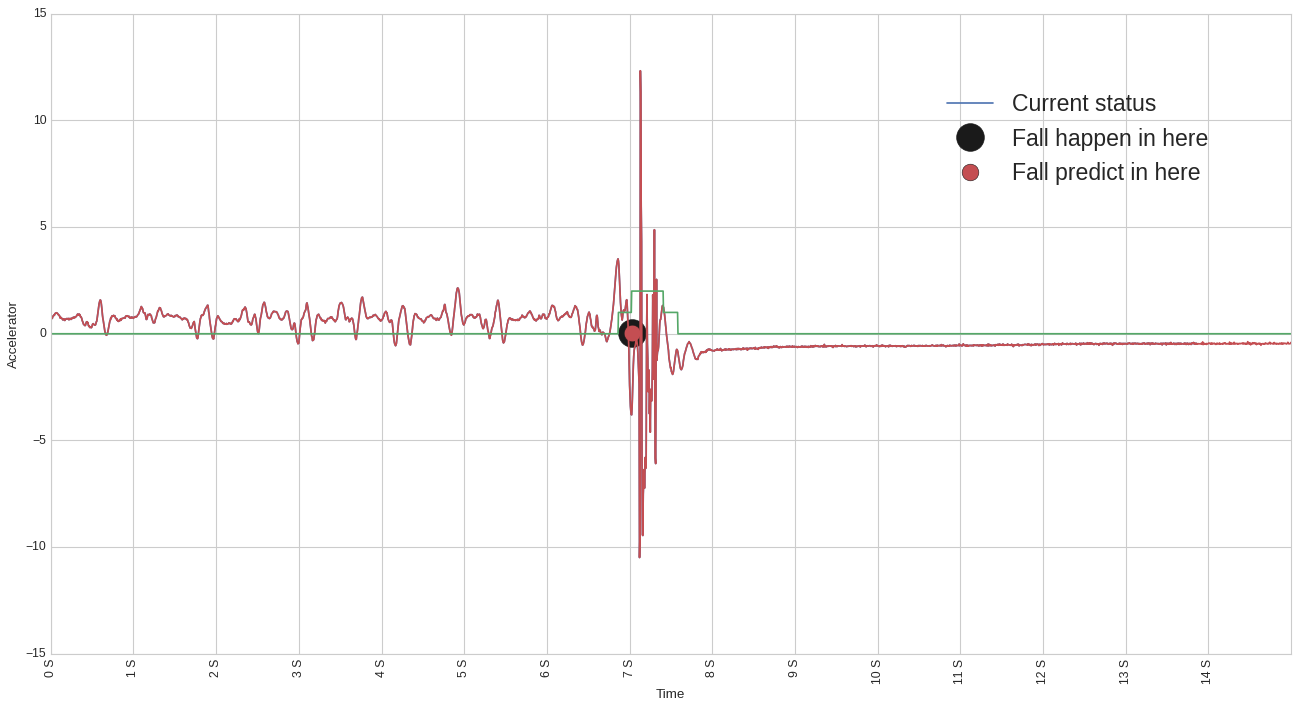

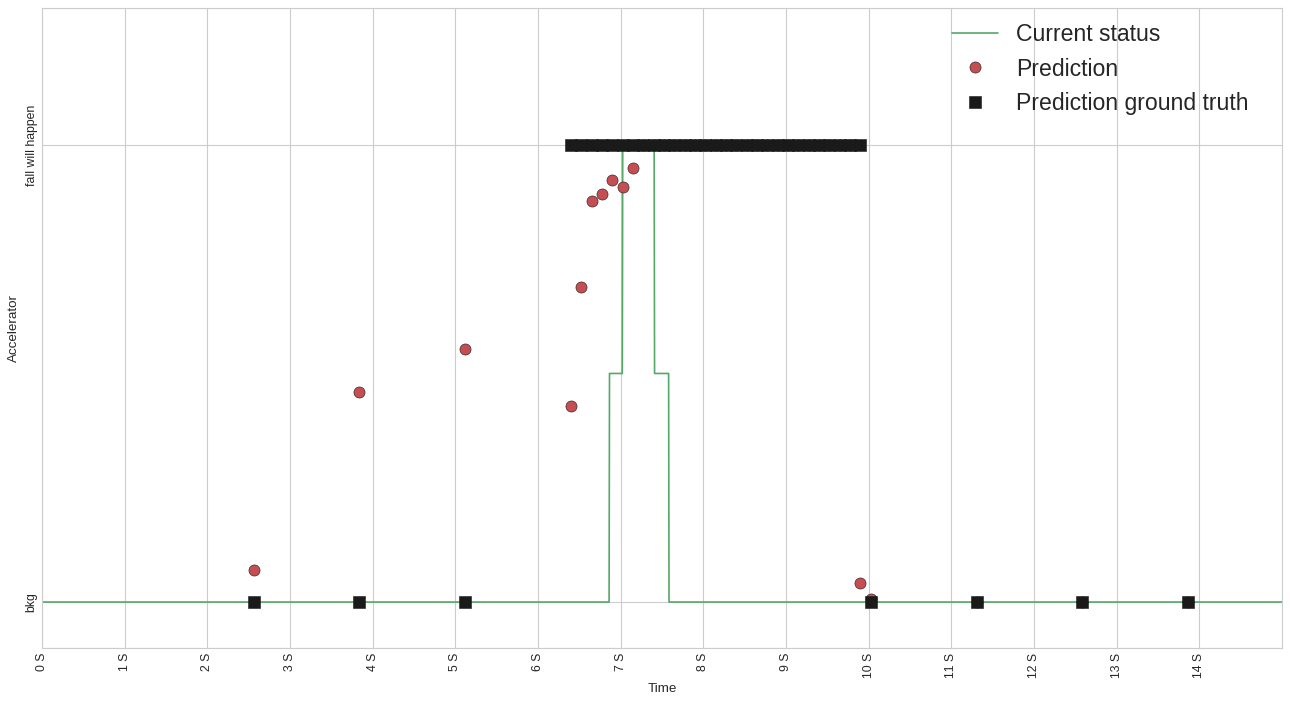

[0, True]

In [185]:
run(Subjet = "SA01",Type = "F01",Repeat = "R01",show=True, post_process=5)

# evaluation

In [186]:
def evaluation(subjectList,post_process=0):
    Missing = 0
    value = []    
    for sub in subjectList:
        for Activite in ["F01","F02","F03","F04","F05","F06","F07","F08","F09","F10","F11","F12","F13","F14","F15"]:
            for Repeat in ["R01","R02","R03","R04","R05"]:
                try:                  
                    [return_value, misslabel] = run(Subjet = sub,Type = Activite,Repeat = Repeat,show=False,post_process=post_process)
                    if(not misslabel):
                        print(f'Subject: {sub}, Activite: {Activite}, Repeat: {Repeat}, return_value : {return_value}')
                        value.append(return_value)
                    else:
                        Missing += 1
                except:
                    pass
        sys.stdout.write('\r'+sub)    
    sys.stdout.write('\r')   
    value = np.array(value)    
    print(f'Missing : {Missing}  *** {round(Missing / (Missing + len(value)),2)}%')
    print(f'Not missing : {len(value)} *** {round(len(value) / (Missing + len(value)),2)}%')    
    print(f'mean: {round(value.mean(),3)}')
    print(f'std : {round(value.std(),3)}')
    return [value, Missing]

# Train

In [ ]:
[value, Missing] = evaluation(["SA11","SA12","SA13","SA14","SA15","SA16","SA17","SA18","SA19","SA20","SA21","SA22","SA23"])

In [ ]:
[value, Missing] = evaluation(["SA11","SA12","SA13","SA14","SA15","SA16","SA17","SA18","SA19","SA20","SA21","SA22","SA23"],post_process=3)

In [ ]:
[value, Missing] = evaluation(["SA11","SA12","SA13","SA14","SA15","SA16","SA17","SA18","SA19","SA20","SA21","SA22","SA23"],post_process=2)

# Validation

In [ ]:
[value, Missing] = evaluation(["SA06","SA07","SA08","SA09","SA10"])

# Test

In [187]:
[value, Missing] = evaluation(["SA01","SA02","SA03","SA04","SA05"])

Subject: SA01, Activite: F01, Repeat: R05, return_value : 0.89
Subject: SA01, Activite: F02, Repeat: R01, return_value : 0.0
Subject: SA01, Activite: F02, Repeat: R02, return_value : 0.055
Subject: SA01, Activite: F02, Repeat: R03, return_value : 0.9
Subject: SA01, Activite: F02, Repeat: R04, return_value : 0.58
Subject: SA01, Activite: F02, Repeat: R05, return_value : 0.0
Subject: SA01, Activite: F03, Repeat: R01, return_value : 0.315
Subject: SA01, Activite: F03, Repeat: R02, return_value : 0.135
Subject: SA01, Activite: F03, Repeat: R03, return_value : 0.0
Subject: SA01, Activite: F06, Repeat: R01, return_value : 0.0
Subject: SA01, Activite: F06, Repeat: R02, return_value : 0.525
Subject: SA01, Activite: F06, Repeat: R03, return_value : 0.55
Subject: SA01, Activite: F06, Repeat: R04, return_value : 0.005
Subject: SA01, Activite: F06, Repeat: R05, return_value : 0.2
Subject: SA01, Activite: F07, Repeat: R02, return_value : 0.54
Subject: SA01, Activite: F07, Repeat: R03, return_value 

In [188]:
[value, Missing] = evaluation(["SA01","SA02","SA03","SA04","SA05"],post_process=1)

Subject: SA01, Activite: F01, Repeat: R01, return_value : 0.625
Subject: SA01, Activite: F01, Repeat: R02, return_value : 0.79
Subject: SA01, Activite: F01, Repeat: R05, return_value : 0.765
Subject: SA01, Activite: F02, Repeat: R01, return_value : 0.0
Subject: SA01, Activite: F02, Repeat: R02, return_value : 0.0
Subject: SA01, Activite: F02, Repeat: R03, return_value : 0.775
Subject: SA01, Activite: F02, Repeat: R04, return_value : 0.455
Subject: SA01, Activite: F02, Repeat: R05, return_value : 0.0
Subject: SA01, Activite: F03, Repeat: R01, return_value : 0.19
Subject: SA01, Activite: F03, Repeat: R02, return_value : 0.01
Subject: SA01, Activite: F03, Repeat: R03, return_value : 0.0
Subject: SA01, Activite: F06, Repeat: R01, return_value : 0.0
Subject: SA01, Activite: F06, Repeat: R02, return_value : 0.4
Subject: SA01, Activite: F06, Repeat: R03, return_value : 0.425
Subject: SA01, Activite: F06, Repeat: R04, return_value : 0.0
Subject: SA01, Activite: F06, Repeat: R05, return_value :